In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.inspection import permutation_importance
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import random
from tqdm import tqdm
import copy
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Чтение данных
Данные предобработаны ноутбуком Split_data_0.ipynb


In [2]:

# Номера агрегатов
agg_l = [4,5,6,7,8,9]
## В дальнейшим будет идти работа со словарем data, ключ data - номер агрегата
data = {}
for agg_num in agg_l:
    data[agg_num] = {}
    df_x = pd.read_parquet(f'dataset_splited/x_train_{agg_num}.parquet')
    df_x_test = pd.read_parquet(f'dataset_splited/x_test_{agg_num}.parquet')
    df_y = pd.read_parquet(f'dataset_splited/y_train_{agg_num}.parquet').astype('uint8')
    data[agg_num]['x_train'] = df_x
    data[agg_num]['x_test_submit'] = df_x_test
    data[agg_num]['y_train'] = df_y


In [3]:
# Приведение колонок из разных агрегатов к одному виду 
def proc_columns_x(df_x):
    x_cols = pd.DataFrame(df_x.columns, columns = ['col'])
    x_cols.loc[x_cols['col']!='target', 'num'] = x_cols.loc[x_cols['col']!='target', \
                                                            'col'].str.extract('ЭКСГАУСТЕР (\d)*').astype(int).values
    x_cols['col_n'] = x_cols['col'].str.replace('ЭКСГАУСТЕР (\d).', '', regex=True).str.strip(' ')
    df_x['agg_num'] = x_cols['num'].mean().astype(int)
    df_x.rename(columns = {i['col']:i['col_n'] for m, i in x_cols.iterrows()}, inplace=True)
    
    
for agg_num in agg_l:
    proc_columns_x(data[agg_num]['x_train'])
    proc_columns_x(data[agg_num]['x_test_submit'])
    data[agg_num]['y_raw_columns'] = data[agg_num]['y_train'].columns
    data[agg_num]['y_train'].columns = data[agg_num]['y_train'].columns\
                                            .str.replace('Y_ЭКСГАУСТЕР А/М №(\d)_', '', regex=True)\
                                            .str.replace('ЭКСГ.№(\d)', '', regex=True)\
                                            .str.replace('ЭКСГ. №(\d)', '', regex=True)\
                                            .str.replace('ЭКСГ.  №(\d)', '', regex=True)\
                                            .str.replace('А/М №(\d)', '', regex=True)\
                                            .str.replace('А/М№(\d)', '', regex=True)\
                                            .str.replace('ЭКСГАУСТЕРА №(\d)', '', regex=True)\
                                            .str.replace('ЭКСГАУСТЕРА№(\d)', '', regex=True)\
                                            .str.replace('ЭКСГАУСТЕРА №(\d)', '', regex=True)\
                                            .str.replace('ВОЗБУДИТЕЛЬ', 'ВЗБ', regex=True)\
                                            .str.replace('ТИРИСТ.', 'ВЗБ', regex=True)\
                                            .str.strip()
    data[agg_num]['y_proc_columns'] = data[agg_num]['y_train'].columns

In [4]:
# Пример датасета для 4 агрегата
# Все агрегаты имеют одинаковую структуру
data[agg_num]['x_train'].head()

,ТОК РОТОРА 1,ТОК РОТОРА 2,ТОК СТАТОРА,ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1,ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2,ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3,ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4,ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ,ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ,ВИБРАЦИЯ НА ОПОРЕ 1,ВИБРАЦИЯ НА ОПОРЕ 2,ВИБРАЦИЯ НА ОПОРЕ 3,ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.,ВИБРАЦИЯ НА ОПОРЕ 4,ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.,agg_num
DT,,,,,,,,,,,,,,,,,
2019-01-16 13:21:00,2.470000,2.470000,0.170000,0.0,20.280000,17.040000,17.040000,15.410000,6.085000,12.170000,0.040000,0.060000,0.080000,0.100000,0.060000,0.080000,9
2019-01-16 13:21:10,2.465278,2.465278,0.173611,0.0,20.038275,17.036613,16.063092,13.790000,5.192110,12.574638,0.033854,0.065972,0.072917,0.086806,0.294271,0.093750,9
2019-01-16 13:21:20,2.328318,2.328318,0.173611,0.0,19.650670,17.036613,16.135206,15.143644,5.680000,11.360000,0.038580,0.068480,0.069444,0.084877,0.265239,0.088735,9
2019-01-16 13:21:30,2.424190,2.424190,0.173611,0.0,19.876022,16.955486,16.063090,14.440548,5.759994,12.574638,0.039931,0.060764,0.067708,0.092882,1.231771,0.078993,9
2019-01-16 13:21:40,2.424190,2.424190,0.190972,0.0,20.119401,16.712107,16.230000,14.846180,4.870000,12.980000,0.035590,0.058160,0.072049,0.087674,1.410000,0.085937,9


# Генерация фичей

### Подготовка датасета

In [5]:
# Удаление ненужных колонок
# ТОК РОТОРА 2 - дубликат ТОК РОТОРА 1
cols_to_drop = ['ТОК РОТОРА 2']
for agg_num in agg_l:
    data[agg_num]['x_train'].drop(columns = cols_to_drop, inplace=True)
    data[agg_num]['x_test_submit'].drop(columns = cols_to_drop, inplace=True)

In [6]:
# квантиля каждого показателя для генерации статистик аномальности
for agg_num in agg_l:
    quantiles = data[agg_num]['x_train'].quantile([0.035, 0.98])
    quantiles.index = ['min', 'max']
    data[agg_num]['thresholds'] = quantiles.T.drop(['agg_num'])

### Генерация фичей для временных рядов

In [7]:
# Функция для генерации фичей - агрегирующих статистик временного ряда
def generate_features(agg_num, table = 'x_train'):
    # используется несколько периода временной агрегации 
    win_sizes = ['1min', '20min', '3h']
    x = pd.DataFrame()
    cols = pd.DataFrame(data[agg_num]['thresholds']['min']).index.values
    for n, ws in enumerate(win_sizes):
        # Сколько фичей за выбранный период агрегации были меньше чем квантиль 0.035
        min_score = (data[agg_num][table][cols]<data[agg_num]['thresholds']['min']).rolling(ws).sum()
        min_score.columns = [f'{i}_{ws}_min_stats' for i in min_score.columns]

        # Сколько фичей за выбранный период агрегации были Больше чем квантиль 0.965 - Не дало скора
#         max_score = (data[agg_num][table][cols]>data[agg_num]['thresholds']['max']).rolling(ws).sum()
#         max_score.columns = [f'{i}_{ws}_max_stats' for i in max_score.columns]

        # Максимальный переход между соседними значениями за выбранный период
        diff_score = data[agg_num][table][cols].diff().abs().rolling(ws).max()
        diff_score.columns = [f'{i}_{ws}_diff_stats' for i in diff_score.columns]
        
        # Суммирующий показатель временного ряда за выбранный период - Не дало скора
#         sum_score = data[agg_num][table][cols].rolling(ws).sum()
#         sum_score.columns = [f'{i}_{ws}_sum_stats' for i in sum_score.columns]
        
        # Std показателя за выбранный период
        std_score = sum_score = data[agg_num][table][cols].rolling(ws).std()
        std_score.columns = [f'{i}_{ws}_std_stats' for i in std_score.columns]
        
        if n==0:
            x = pd.concat([min_score, diff_score, std_score], axis=1)
        else:
            x = pd.concat([x, min_score, diff_score, std_score], axis=1)
        
        del min_score, diff_score, std_score
    
    # Сколько фичей принимали значения nan
    nan_score = data[agg_num][table].isna().sum(axis=1)
    data[agg_num][table] = x
    data[agg_num][table]['nan_score'] = nan_score
    

In [8]:
# Добавление в тест данные из трейна дл расчета агрегирующих статистик.
# В дальнейшим будет удалено
test_start_dt = data[agg_num]['x_test_submit'].index[0]
for agg_num in tqdm(agg_l):
    data_from_train = data[agg_num]['x_train'][test_start_dt-pd.Timedelta(days=1):]
    data[agg_num]['x_test_submit'] = pd.concat([data_from_train, data[agg_num]['x_test_submit']])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.35it/s]


In [9]:
# Генерация признаков для каждого агрегата
for agg_num in tqdm(agg_l):
    generate_features(agg_num, 'x_train')
    generate_features(agg_num, 'x_test_submit')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:42<00:00, 57.07s/it]


In [10]:
## Удаление данных из трейна в тесте
for agg_num in tqdm(agg_l):
    data[agg_num]['x_test_submit'] = data[agg_num]['x_test_submit'].loc[test_start_dt:]

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 214.29it/s]


### Обрезка таблицы для обучения

In [11]:
cut_old_data = '2020-01-01 00:00:00'
for agg_num in agg_l:
    # Удаление старых данных - распределение скорее всего неактуально
    data[agg_num]['x_train'] = data[agg_num]['x_train'].loc[cut_old_data:]
    data[agg_num]['y_train'] = data[agg_num]['y_train'].loc[cut_old_data:]
    
    # Т.к. для агрегирующих статистик соседние наблюдения будут очень похожи, можно избавиться от части данных
    data[agg_num]['x_train'] = data[agg_num]['x_train'][::20]
    data[agg_num]['y_train'] = data[agg_num]['y_train'][::20]

## Train \ test split

In [12]:
# С какой даты будет разделение на train\test
train_test_datetime_thresh = '2021-09-15 00:00:00'

In [13]:
# нормировка данных и разделение на train\test
for agg_num in agg_l:
    # Стандартизаиця данных
    data[agg_num]['means'] = data[agg_num]['x_train'].mean()
    data[agg_num]['std'] = data[agg_num]['x_train'].std()
    data[agg_num]['x_train'] = (data[agg_num]['x_train'] - data[agg_num]['means'])\
                                    /data[agg_num]['std']
    data[agg_num]['x_test_submit'] = (data[agg_num]['x_test_submit'] - data[agg_num]['means'])\
                                    /data[agg_num]['std']
    
    # Алгорит заполнение пропусков:
    # 1. Заполнить последним известным значением
    # 2. Заполнить медианой из трейна
    # 3. Убрать фичу, если в ней остались пропуски
    median = data[agg_num]['x_train'].median()
    data[agg_num]['median'] = median
    data[agg_num]['x_train'] = data[agg_num]['x_train'].fillna(method='ffill').fillna(median)
    data[agg_num]['x_test_submit'] = \
                data[agg_num]['x_test_submit'].fillna(method='ffill').fillna(median)
    data[agg_num]['x_train'] = data[agg_num]['x_train'].dropna(axis=1)
    data[agg_num]['x_test_submit'] = data[agg_num]['x_test_submit'][data[agg_num]['x_train'].columns]
    
    # В силу аномального поведения M1 (редкое событие) оно будет засчиано как M3
    data[agg_num]['y_train'] = data[agg_num]['y_train'].isin([1,2]).astype('uint8')
    
    # x_test - тест на внутренней валидации
    # x_test_submit - тест для отправки
    data[agg_num]['x_test'] = data[agg_num]['x_train'].loc[train_test_datetime_thresh:]
    data[agg_num]['y_test'] = data[agg_num]['y_train'].loc[train_test_datetime_thresh:]
    data[agg_num]['x_train'] = data[agg_num]['x_train'].loc[:train_test_datetime_thresh]
    data[agg_num]['y_train'] = data[agg_num]['y_train'].loc[:train_test_datetime_thresh]

# Обучение моделей

In [14]:
# Предиктивная модель - простая FFN сеть 
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(LogisticRegression, self).__init__()
        self.linear_1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear_2 = torch.nn.Linear(hidden_dim, output_dim)
        self.relu = torch.nn.ReLU() 
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear_2(self.relu(self.linear_1(x))))
        return outputs
    

# Метрика из ТЗ
def calc_metrics(y, pred):
    TP = ((pred==1) & (y==1)).sum()
    FP = ((pred==1) & (y==0)).sum()
    FN = ((pred==0) & (y==1)).sum()
    return TP/(TP+FP+FN)

In [15]:
# Вспомогательные функции

# отрисовка метрик моделей
def draw_metrics(metrics_train, metrics_test, loss, agg_num):
    plt.plot(metrics_train, '-o', label = 'train')
    plt.plot(metrics_test, '-o', label='test')
    plt.legend()
    plt.title(f'Score by epochs for aggregate {agg_num}')
    plt.show()
#     plt.plot(loss_list, '-o')
#     plt.title(f'Binary CE for aggregate {agg_num}')
#     plt.show()
    
# отрисовка метрик моделей
def calc_feature_imp(x, y, x_cols):
    baseline_pred = model(x)
    baseline_score = calc_metrics(y, baseline_pred)
    feature_imps = []
    for f_num in np.arange(x.shape[1]):
        x_shuffle = copy.deepcopy(x)
        idx = torch.randperm(x_shuffle.shape[0])
        x_shuffle[:,f_num] = x_shuffle[:,f_num][idx]
        pred = model(x_shuffle)
        score = calc_metrics(pred, y)
        imp = baseline_score.nan_to_num(0) - score.nan_to_num(0)
        feature_imps.append({'feature':x_cols[f_num], 'imp':float(imp.detach().numpy())})
    feature_imps = pd.DataFrame(feature_imps)
    feature_imps['imp_abs'] = feature_imps['imp'].abs()
    feature_imps = feature_imps.sort_values('imp_abs')[::-1]    
    feature_imps['stat_type'] = feature_imps['feature'].str.split('_').str[-2]
    feature_imps['feature_original'] = feature_imps['feature'].str.split('_').str[0]
    feature_imps['win_size'] = feature_imps['feature'].str.split('_').str[-3]
    return feature_imps

def draw_feature_imp(f_imp, agg_num):
    sns.barplot(data=f_imp[:20], x='imp_abs', y='feature')
    plt.title(f'Top 20 features for aggregate {agg_num}')
    plt.show()

    sns.barplot(data = f_imp[['feature_original', 'imp_abs']]\
                        .groupby('feature_original', as_index=False).mean().sort_values('imp_abs')[::-1],
                               x = 'imp_abs', y='feature_original')
    plt.title(f'Feature importance by feature name for aggregate {agg_num}')
    plt.xticks(rotation=45)
    plt.show()

    sns.barplot(data = f_imp[['stat_type', 'imp_abs']]\
                        .groupby('stat_type', as_index=False).mean().sort_values('imp_abs')[::-1],
                               x = 'imp_abs', y='stat_type')
    plt.title(f'Feature importance by statistic type for aggregate {agg_num}')
    plt.xticks(rotation=45)
    plt.show()

    sns.barplot(data = f_imp[['win_size', 'imp_abs']]\
                        .groupby('win_size', as_index=False).mean().sort_values('imp_abs')[::-1],
                               x = 'imp_abs', y='win_size')
    plt.title(f'Feature importance by windows_size for aggregate {agg_num}')
    plt.xticks(rotation=45)
    plt.show()

In [26]:
## Гиперпараметры обучения
epochs = 32
learning_rate = 0.000015
batch_size = 256
weight_decay = 0.1

Training Epochs for aggregate 4: 100%|█████████████████████████████████████████████████| 32/32 [00:26<00:00,  1.20it/s]

Results for agg_num: 4


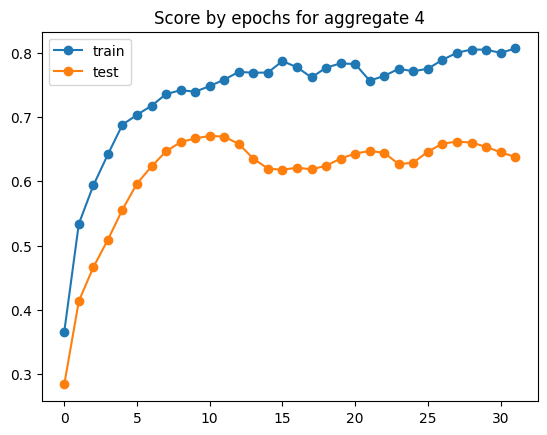

Training Epochs for aggregate 5: 100%|█████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.03s/it]

Results for agg_num: 5


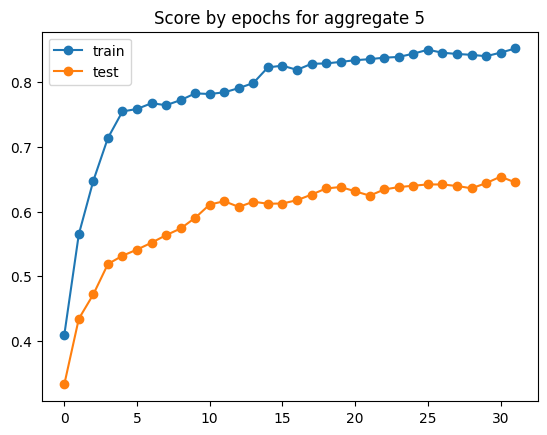

Training Epochs for aggregate 6: 100%|█████████████████████████████████████████████████| 32/32 [00:29<00:00,  1.10it/s]

Results for agg_num: 6


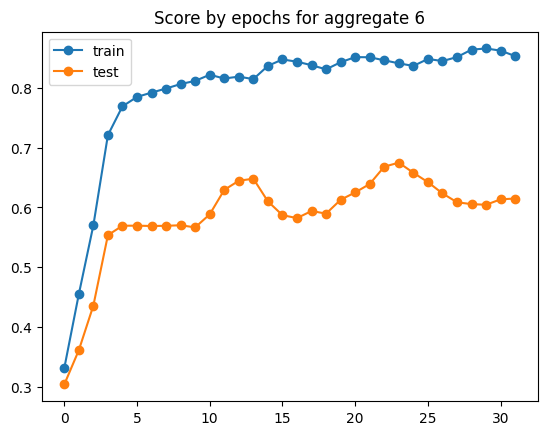

Training Epochs for aggregate 7: 100%|█████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Results for agg_num: 7


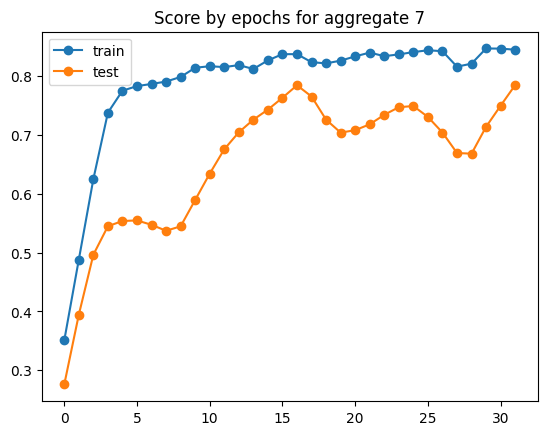

Training Epochs for aggregate 8: 100%|█████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Results for agg_num: 8


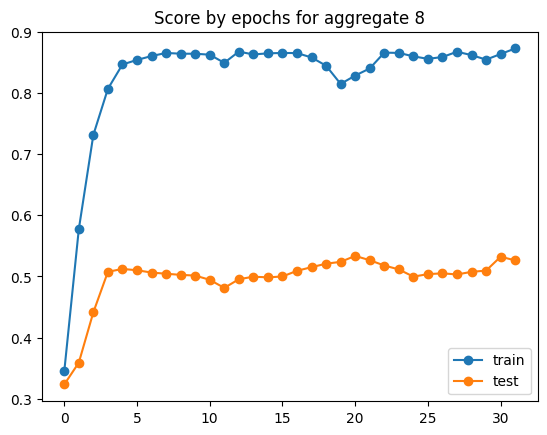

Training Epochs for aggregate 9: 100%|█████████████████████████████████████████████████| 32/32 [00:28<00:00,  1.11it/s]

Results for agg_num: 9


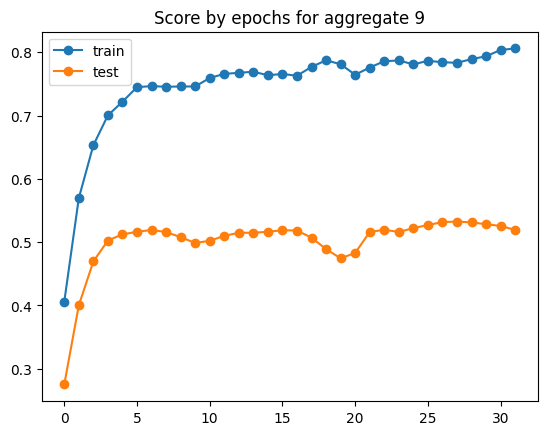

In [27]:
feat_imps = pd.DataFrame()
for agg_num in agg_l:
    x_cols = list(data[agg_num]['x_train'])
    if 'agg_num' in x_cols: x_cols.remove('agg_num')
        
    criterion = torch.nn.BCELoss()
    model = LogisticRegression(data[agg_num]['x_train'].shape[1], data[agg_num]['y_train'].shape[1],
                              hidden_dim = int(1*data[agg_num]['y_train'].shape[1]))
    optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    x_train = torch.Tensor(data[agg_num]['x_train'].values)
    y_train = torch.Tensor(data[agg_num]['y_train'].values)
    x_test = torch.Tensor(data[agg_num]['x_test'].values)
    y_test = torch.Tensor(data[agg_num]['y_test'].values)
    
    loss_list = []
    metrics_train = []
    metrics_test = []
    
    
    for epoch in tqdm(range(int(epochs)),desc=f'Training Epochs for aggregate {agg_num}'):
        indexes = np.arange(x_train.shape[0])
        np.random.shuffle(indexes)
        
        loss_list_b = []
        for b in range(int(len(indexes)/batch_size)):
            indexes_batch = indexes[b*batch_size:(b+1)*batch_size]
            x_train_batch = x_train[indexes_batch]
            y_train_batch = y_train[indexes_batch]
            outputs = model(x_train_batch)
            loss = criterion(torch.squeeze(outputs), y_train_batch) 
            loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
            optimizer.step() # Updates weights and biases with the optimizer (SGD)
            loss_list_b.append(float(loss.detach().numpy()))
        loss_list.append(np.mean(loss_list_b))
        
        pred_train = model(x_train).round()
        pred_test = model(x_test).round()
        metrics_train.append(calc_metrics(y_train, pred_train))
        metrics_test.append(calc_metrics(y_test, pred_test))
        
    model.x_cols = x_cols
    model.means = [data[agg_num]['means'][i] for i in x_cols]
    model.std = [data[agg_num]['std'][i] for i in x_cols]
    model.thresholds_min = data[agg_num]['thresholds']['min'].to_dict()
    model.thresholds_max = data[agg_num]['thresholds']['max'].to_dict()
    model.median = data[agg_num]['median'].to_dict()
    model.y_proc_columns = list(data[agg_num]['y_proc_columns'])
    model.y_raw_columns = list(data[agg_num]['y_raw_columns'])
    
    metrics_train = [i.nan_to_num(0) for i in metrics_train]
    metrics_test = [i.nan_to_num(0) for i in metrics_test]
    
    data[agg_num]['model'] = copy.deepcopy(model)
    print(f'Results for agg_num: {agg_num}')
    draw_metrics(metrics_train, metrics_test, loss, agg_num)
#     f_imp = calc_feature_imp(x_test, y_test, x_cols)
#     draw_feature_imp(f_imp, agg_num)
    torch.save(model, f'models_task_2/model_agg_num_{agg_num}.pt')
    print('============================================')

## Предикт на тесте для отправки

In [ ]:
y_cols_submit = []
for agg_num in agg_l:
    y_cols_submit += list(data[agg_num]['y_raw_columns'])
    
df_test_submit = pd.DataFrame(index = data[4]['x_test_submit'].index, columns = y_cols_submit)

In [ ]:
for agg_num in agg_l:
    x_test_submit = torch.Tensor(data[agg_num]['x_test_submit'].values)
    pred = data[agg_num]['model'](x_test_submit).detach().numpy()
    df_test_submit.loc[:, data[agg_num]['y_train'].columns] = pred
    
df_test_submit = (df_test_submit.rolling('3h').mean().round().rolling('3h').max()*2).astype('uint8')

In [ ]:
df_test_submit.to_parquet('task_2.parquet')